In [1]:
#!pip install wfdb

In [2]:
# Importing needed libraries
from matplotlib import pyplot as plt
from wfdb.io import get_record_list
from wfdb import rdsamp, processing
import numpy as np
import random
from scipy.signal import resample_poly
from pickle import dump, load
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.metrics import recall_score

import utils
from data_generator import dataset_gen

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading data

In [3]:
load_flag = False
if load_flag:
    # import files
    mitdb_records = get_record_list('mitdb')
    mitdb_signals, mitdb_beats, mitdb_beat_types = utils.data_from_records(mitdb_records, channel=0, db='mitdb')
    # save file
    dump(mitdb_signals, open('./mitdb_signals.pkl', 'wb'))
    dump(mitdb_beats, open('./mitdb_beats.pkl', 'wb'))
    dump(mitdb_beat_types, open('./mitdb_beat_types.pkl', 'wb'))
else:
    mitdb_signals = load(open('./mitdb_signals.pkl', 'rb'))
    mitdb_beats = load(open('./mitdb_beats.pkl', 'rb'))
    mitdb_beat_types = load(open('./mitdb_beat_types.pkl', 'rb'))


## Different R-peak types

In [4]:
# Extract beat symbols from all records
all_symbols = []
for symbols in mitdb_beat_types:
    all_symbols.append(symbols)
    
all_symbols = [item for sublist in all_symbols for item in sublist]
all_symbols = np.asarray(all_symbols)
u, c = np.unique(all_symbols, return_counts=True)

# Meanings for different heart beat codings
label_meanings = {
    "N": "Normal beat",
    "L": "Left bundle branch block beat",
    "R": "Right bundle branch block beat",
    "V": "Premature ventricular contraction",
    "/": "Paced beat",
    "A": "Atrial premature beat",
    "f": "Fusion of paced and normal beat",
    "F": "Fusion of ventricular and normal beat",
    "j": "Nodal (junctional) escape beat",
    "a": "Aberrated atrial premature beat",
    "E": "Ventricular escape beat",
    "J": "Nodal (junctional) premature beat",
    "Q": "Unclassifiable beat",
    "e": "Atrial escape beat",
    "S": "Supraventricular premature or ectopic"
}

# Print number of instances in each beat type
label_counts = [(label, count) for label, count in zip(u.tolist(), c.tolist())]
label_counts.sort(key=lambda tup: tup[1], reverse=True)
for label in label_counts:
    print(label_meanings[label[0]], "-"*(40-len(label_meanings[label[0]])), label[1])

Normal beat ----------------------------- 75052
Left bundle branch block beat ----------- 8075
Right bundle branch block beat ---------- 7259
Premature ventricular contraction ------- 7130
Paced beat ------------------------------ 7028
Atrial premature beat ------------------- 2546
Fusion of paced and normal beat --------- 982
Fusion of ventricular and normal beat --- 803
Nodal (junctional) escape beat ---------- 229
Aberrated atrial premature beat --------- 150
Ventricular escape beat ----------------- 106
Nodal (junctional) premature beat ------- 83
Unclassifiable beat --------------------- 33
Atrial escape beat ---------------------- 16
Supraventricular premature or ectopic --- 2


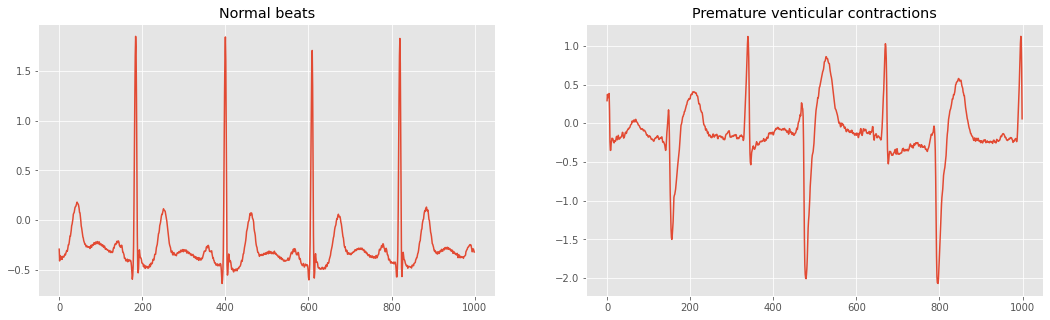

In [5]:
# Plot examples of beat types
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5), fig.set_figwidth(18)
ax1.plot(mitdb_signals[3][:1000])
ax1.set_title('Normal beats')
ax2.plot(mitdb_signals[23][:1000])
ax2.set_title('Premature venticular contractions')
plt.show()

## Converting character encodings to numerical

In [6]:
# Create dictionary that encodes characters as numerical
label_codings = {}
for i in range(0, len(label_counts)):
    if label_counts[i][0] == 'N':
        label_codings[label_counts[i][0]] = 1
    else:
        label_codings[label_counts[i][0]] = -1
label_codings

{'N': 1,
 'L': -1,
 'R': -1,
 'V': -1,
 '/': -1,
 'A': -1,
 'f': -1,
 'F': -1,
 'j': -1,
 'a': -1,
 'E': -1,
 'J': -1,
 'Q': -1,
 'e': -1,
 'S': -1}

In [7]:
# Save new numerical encodings as list
mitdb_labels = []
for beat_types in mitdb_beat_types:
    numerical_symbols = [label_codings[sym] for sym in beat_types]
    mitdb_labels.append(np.asarray(numerical_symbols))
    
mitdb_labels[:5]

[array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([-1, -1, -1, ..., -1, -1, -1])]

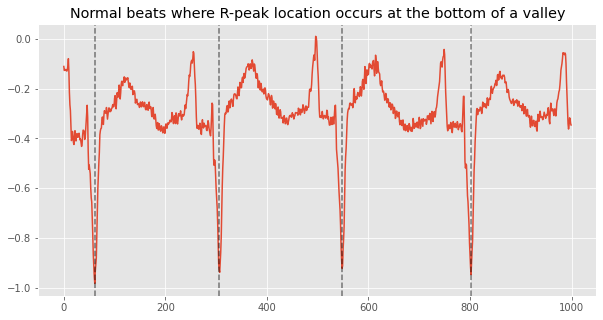

In [8]:
# Plot signal and beat locations as dashed line
plt.figure(figsize=(10,5))
plt.plot(mitdb_signals[8][:1000])
for peak in mitdb_beats[8][:4]:
    plt.axvline(x=peak, color='k', linestyle='--', alpha=0.5)
plt.title('Normal beats where R-peak location occurs at the bottom of a valley')
plt.show()

In [9]:
mitdb_labels = utils.fix_labels(mitdb_signals, mitdb_beats, mitdb_labels)

## Plot the noise

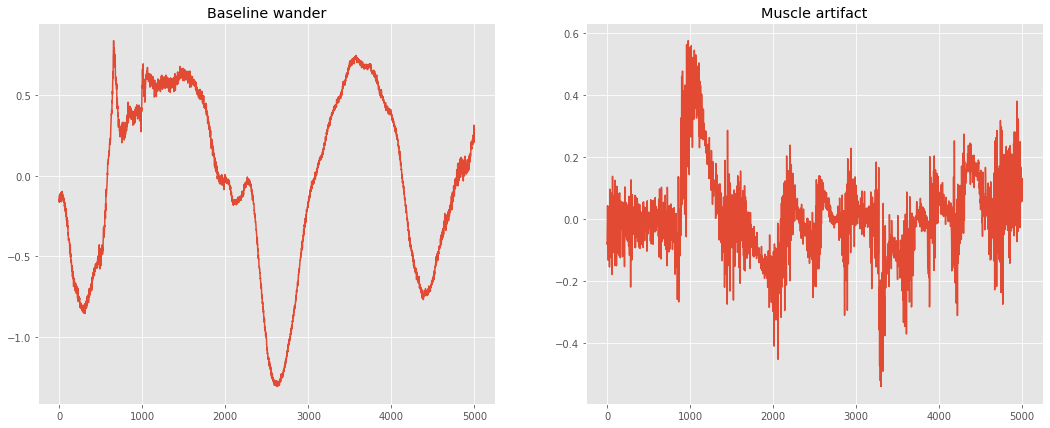

In [10]:
# Load data
baseline_wander = rdsamp('bw', pn_dir='nstdb')
muscle_artifact = rdsamp('ma', pn_dir='nstdb')

# Concatenate two channels to make one longer recording
ma = np.concatenate((muscle_artifact[0][:,0], muscle_artifact[0][:,1]))
bw = np.concatenate((baseline_wander[0][:,0], baseline_wander[0][:,1]))

# Resample noise to 250 Hz
ma = resample_poly(ma, up=250, down=muscle_artifact[1]['fs'])
bw = resample_poly(bw, up=250, down=baseline_wander[1]['fs'])

# Plot examples of baseline wandering and muscle artifact noise types
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7), fig.set_figwidth(18)
ax1.plot(bw[:5000])
ax1.set_title('Baseline wander')
ax2.plot(ma[:5000])
ax2.set_title('Muscle artifact')
plt.show()

## Create data loader

In [11]:
precent_train = 0.7

# create list of train and validation indexs
index_list = list(range(len(mitdb_signals)))
random.shuffle(index_list)
num_assets_train = int(precent_train * len(index_list))
index_train = index_list[:num_assets_train]
index_validation = index_list[num_assets_train:]

print('Number of examples in training is %d and in validation is %d' % (len(index_train),len(index_validation)))

Number of examples in training is 33 and in validation is 15


In [12]:
# Define Training Data
n_batch = 256
win_size = 1000

train_dataset = dataset_gen(signals=[mitdb_signals[i] for i in index_train], 
                            peaks=[mitdb_beats[i] for i in index_train], 
                            labels=[mitdb_labels[i] for i in index_train], 
                            ma=ma,
                            bw=bw,
                            win_size=win_size)

train_loader = data.DataLoader(train_dataset, 
                               batch_size=n_batch, 
                               shuffle=True)

# Define Validation Data
validation_dataset = dataset_gen(signals=[mitdb_signals[i] for i in index_validation], 
                            peaks=[mitdb_beats[i] for i in index_validation], 
                            labels=[mitdb_labels[i] for i in index_validation], 
                            ma=ma,
                            bw=bw,
                            win_size=win_size)

validation_loader = data.DataLoader(validation_dataset, 
                                    batch_size=n_batch, 
                                    shuffle=True)

## Evaluate model

In [85]:
y = []
y_pred = []
offset = 9

# turn off gradients for evalute
with torch.no_grad():
    for i,batch in enumerate(validation_loader):
        # get batch images and labels
        X,y_true = batch 
        X,y_true = X.flatten().numpy(), y_true.flatten().numpy()
        
        for i in range(X.shape[0]):
            qrs_locs = processing.gqrs_detect(X, fs=250)
            y_pred_batch = np.zeros(y_true.shape)
            #  add offset, and expand peak
            qrs_locs = qrs_locs + offset
            y_pred_batch[qrs_locs] = 1
            y_pred_batch[qrs_locs+1] = 1
            y_pred_batch[qrs_locs+2] = 1
            y_pred_batch[qrs_locs-1] = 1
            y_pred_batch[qrs_locs-2] = 1
            
        # save to vectore
        y.append(y_true.tolist())
        y_pred.append(np.around(y_pred_batch).tolist())

# flat arrays
y = np.array([item for sublist in y for item in sublist]).astype(int)
y_pred = np.array([item for sublist in y_pred for item in sublist]).astype(int)   

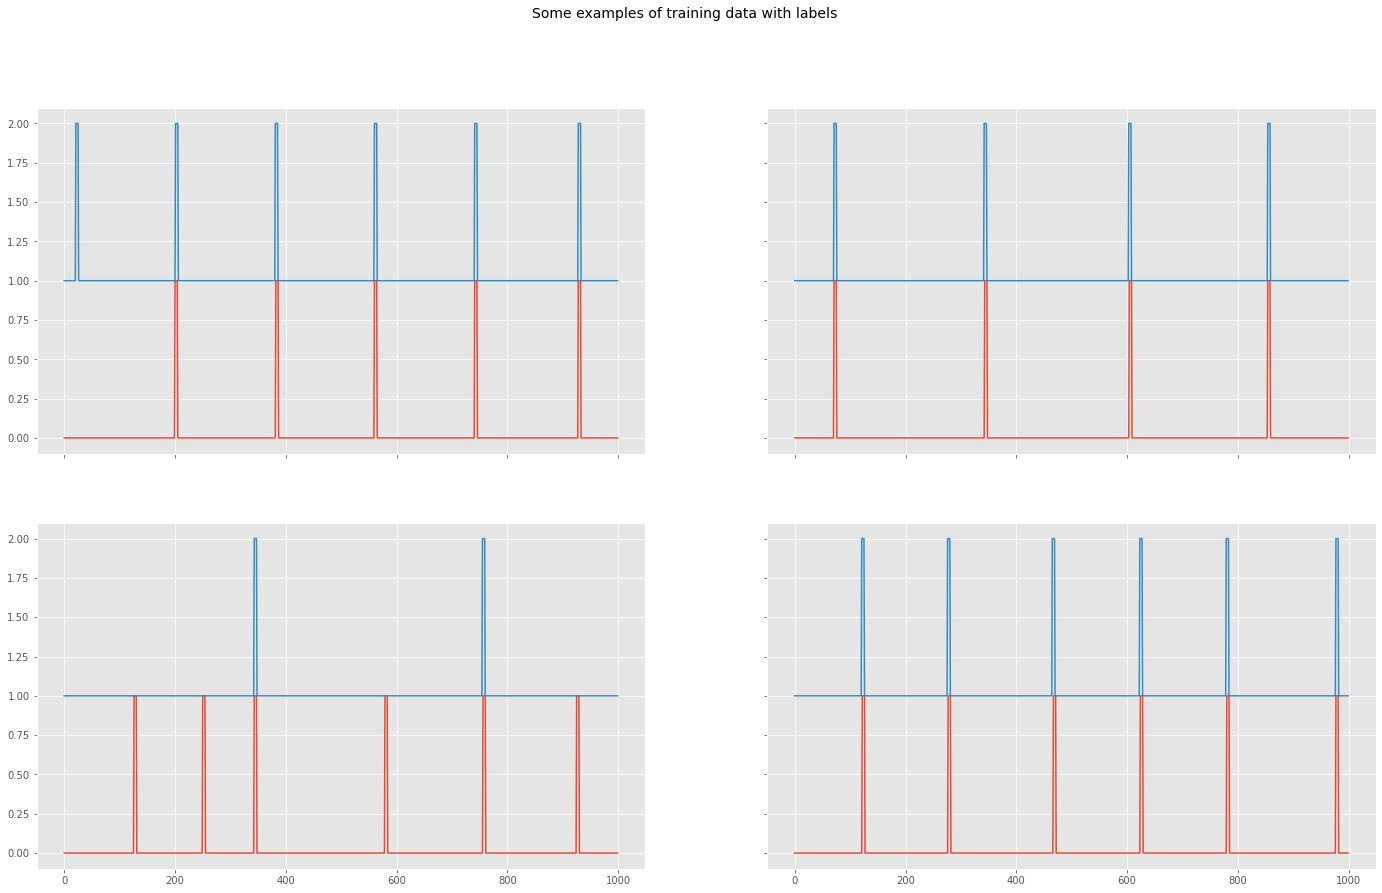

In [86]:
# Plot 4 training examples with labels
fig, axs = plt.subplots(2, 2)
fig.set_figheight(14), fig.set_figwidth(24)
fig.suptitle('Some examples of training data with labels', size=14)

axs[0, 0].plot(y_pred_batch[:1000])
axs[0, 0].plot(y_true[:1000]+1)

axs[0, 1].plot(y_pred_batch[1000:2000])
axs[0, 1].plot(y_true[1000:2000]+1)

axs[1, 0].plot(y_pred_batch[2000:3000])
axs[1, 0].plot(y_true[2000:3000]+1)

axs[1, 1].plot(y_pred_batch[3000:4000])
axs[1, 1].plot(y_true[3000:4000]+1)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [87]:
# calculate recall and specificty
recall = recall_score(y, y_pred) * 100
specificty = recall_score(y, y_pred, pos_label = 0) * 100
print('For gqrs algorithm, Recall is %.3f and Specificity is %.3f' % (recall, specificty))

For gqrs algorithm, Recall is 68.533 and Specificity is 98.749


## Print Single example

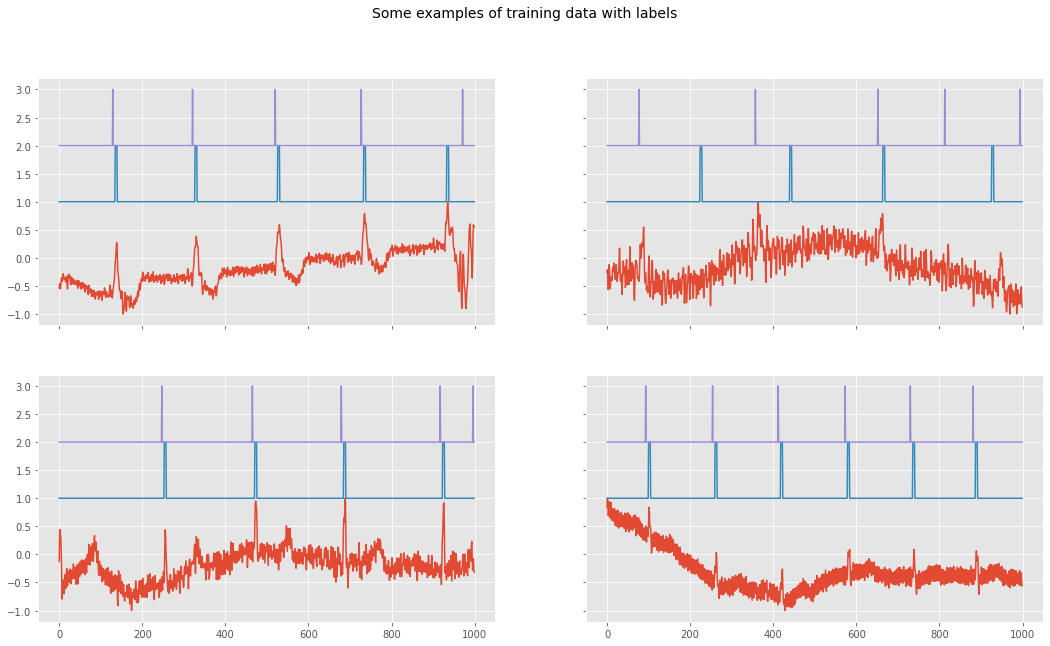

In [24]:
# Plot 4 training examples with labels
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10), fig.set_figwidth(18)
fig.suptitle('Some examples of training data with labels', size=14)

axs[0, 0].plot(X[:1000])
axs[0, 0].plot(y[:1000]+1)
axs[0, 0].plot(y_pred[:1000]+2)

axs[0, 1].plot(X[1000:2000])
axs[0, 1].plot(y[1000:2000]+1)
axs[0, 1].plot(y_pred[1000:2000]+2)

axs[1, 0].plot(X[2000:3000])
axs[1, 0].plot(y[2000:3000]+1)
axs[1, 0].plot(y_pred[2000:3000]+2)

axs[1, 1].plot(X[3000:4000])
axs[1, 1].plot(y[3000:4000]+1)
axs[1, 1].plot(y_pred[3000:4000]+2)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()